# Employee Productivity Prediction Using Tree Models

## Load Data

In [201]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/garments_worker_productivity.csv', parse_dates=['date'])

## Examine

In [202]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    691 non-null    float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

### Column Descriptions

date: date in MM-DD-YYYY

quarter: a portion of the month — month was divided into four quarters

department: associated department with the instance

day: day of the week

team: associated team number with the instance

targeted_productivity: targeted productivity set by the authority for each team for each day

smv: standard minute value — the allocated time for a task

wip: work in progress — includes the number of unfinished items for products

over_time: represents the amount of overtime by each team in minutes

incentive: represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action

idle_time: the duration of time when the production was interrupted due to several reasons

idle_men: the number of workers who were idle due to production interruption

no_of_style_change: number of changes in the style of a particular product

no_of_workers: number of workers on each team

actual_productivity: the actual % of productivity that was delivered by the workers — it ranges from 0 to 1.

In [204]:
df.shape

(1197, 15)

### Check Nulls

In [205]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

### Check Categorical Column Value Counts

In [206]:
cols = ['quarter', 'department', 'day', 'team']

for col in cols:
    print(f'{df[col].value_counts()}\n')

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

department
sweing        691
finishing     257
finishing     249
Name: count, dtype: int64

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64

team
8     109
2     109
4     105
1     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64



### Quick Findings:

#### `quarter`:

- 5th quarter exists.

#### `department`:

- Typo in "sweing"
- Two "finishing" values, perhaps whitespace

#### `day`:

- All days except "Friday", perhaps no production on Fridays

#### `team`:

- 12 total teams

### Comparing Related Columns

In [207]:
df[['targeted_productivity', 'actual_productivity']].describe()

,targeted_productivity,actual_productivity
count,1197.000000,1197.000000
mean,0.729632,0.735091
std,0.097891,0.174488
min,0.070000,0.233705
25%,0.700000,0.650307
50%,0.750000,0.773333
75%,0.800000,0.850253
max,0.800000,1.120437


We can see some abnormal values, specifically within `actual_productivity`. The max value seems to be above the possible productivity value (a scale from 0-100%), as it is observed as 1.12 (112%) productivity. Let's check this column's unique values.

In [208]:
df.loc[df['actual_productivity'] > 1, 'actual_productivity'].value_counts(dropna=False).sort_index(ascending=False)

actual_productivity
1.120437     1
1.108125     1
1.100484     1
1.096633     1
1.059621     1
1.057963     1
1.050667     1
1.050281     1
1.033570     1
1.033156     1
1.020000     1
1.011562     1
1.004889     1
1.001417     1
1.000671     1
1.000602     1
1.000457     1
1.000446     1
1.000402     1
1.000345     2
1.000230    11
1.000066     1
1.000019     4
Name: count, dtype: int64

In [209]:
print('Observations Where Actual Productivity > 1: ',df.loc[df['actual_productivity'] > 1, 'actual_productivity'].count())
print('Total Observations ', df.shape[0])
print('Proportion: ', round(df.loc[df['actual_productivity'] > 1, 'actual_productivity'].count() / df.shape[0], 2))

Observations Where Actual Productivity > 1:  37
Total Observations  1197
Proportion:  0.03


We could deal with this problem a couple of ways. 

We could: 

- Scale the data
- Replace the values with 1.0 as they effectively max out the scale

As these abnormalities seem to only occur on a small fraction of our overall observations, we will simply replace the values with the maximum of our scale, in order to avoid altering the scaling between `target_productivity` as well. We could have also scaled `target_productivity` to the same scaling, but this method is quicker as there are only a few problematic observations.

We'll clean this in the next section.

## Cleaning

### `actual_productivity`

We'll simply cap off our abnormal values to max out at 1.0.

In [210]:
df.loc[df['actual_productivity'] > 1, 'actual_productivity'] = 1

In [211]:
df[['targeted_productivity', 'actual_productivity']].describe()

,targeted_productivity,actual_productivity
count,1197.000000,1197.000000
mean,0.729632,0.734461
std,0.097891,0.173380
min,0.070000,0.233705
25%,0.700000,0.650307
50%,0.750000,0.773333
75%,0.800000,0.850253
max,0.800000,1.000000


### `wip` and `department` columns

In [212]:
df['wip'].value_counts(dropna=False).sort_values(ascending=False)

wip
NaN       506
1039.0      5
1282.0      4
1108.0      3
1138.0      3
         ... 
1674.0      1
290.0       1
971.0       1
992.0       1
984.0       1
Name: count, Length: 549, dtype: int64

In [213]:
df[df['wip'].isnull()].sample(5)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
521,2015-01-31,Quarter5,finishing,Saturday,3,0.80,3.94,NaN,960,0,0.0,0,0,8.0,0.971867
735,2015-02-12,Quarter2,finishing,Thursday,8,0.35,4.15,NaN,1440,0,0.0,0,0,12.0,0.755486
20,2015-01-03,Quarter1,finishing,Saturday,11,0.75,2.90,NaN,5640,0,0.0,0,0,17.0,0.987880
226,2015-01-13,Quarter2,finishing,Tuesday,2,0.80,3.94,NaN,1440,0,0.0,0,0,8.0,0.805909
505,2015-01-29,Quarter5,finishing,Thursday,11,0.60,2.90,NaN,960,0,0.0,0,0,8.0,0.864583


We will drill down into cases surrounding null values. Perhaps null `wip` entries are due to preceding or upcoming weeks.

In [214]:
df.iloc[309:322]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
309,2015-01-18,Quarter3,sweing,Sunday,12,0.80,26.87,585.0,5670,56,0.0,0,0,31.5,0.662256
310,2015-01-18,Quarter3,sweing,Sunday,3,0.65,22.52,1138.0,10170,35,0.0,0,0,56.5,0.650417
311,2015-01-18,Quarter3,sweing,Sunday,11,0.65,14.89,1140.0,10260,44,0.0,0,0,57.0,0.650300
312,2015-01-18,Quarter3,sweing,Sunday,2,0.65,22.94,1025.0,10170,26,0.0,0,0,56.5,0.650243
313,2015-01-18,Quarter3,finishing,Sunday,8,0.80,2.90,NaN,1440,0,0.0,0,0,8.0,0.639867
314,2015-01-18,Quarter3,sweing,Sunday,5,0.60,20.40,1031.0,10440,30,0.0,0,0,58.0,0.600063
315,2015-01-18,Quarter3,finishing,Sunday,9,0.80,3.94,NaN,1800,0,0.0,0,0,10.0,0.582045
316,2015-01-18,Quarter3,sweing,Sunday,1,0.80,49.10,1381.0,10350,24,0.0,0,0,57.5,0.403242
317,2015-01-18,Quarter3,finishing,Sunday,10,0.70,3.94,NaN,1440,0,0.0,0,0,8.0,0.235795
318,2015-01-19,Quarter3,finishing,Monday,4,0.70,4.30,NaN,5040,0,0.0,0,0,28.0,0.977273


Seeing this specific slice of our data, we can identify an interesting pattern. The cases in which `wip` is missing all occur in the finishing department. Lets see what other entries the finishing department in particular contains in comparison to the rest. Also we need to clean `department` anyways, due to two existing "finishing" values.

In [215]:
df['department'].unique().tolist()

['sweing', 'finishing ', 'finishing']

We can see that our earlier theory was correct—there is whitespace proceeding one of the values. We will correct this.

In [216]:
df['department'] = df['department'].replace('finishing ', 'finishing')

We will also correct the type on "sewing"

In [217]:
df['department'] = df['department'].replace('sweing', 'sewing')

In [218]:
df['department'].unique().tolist()

['sewing', 'finishing']

Now we can check for null `wip` values by `department`

In [219]:
df.loc[df['department'] == 'sewing', 'wip'].isnull().sum()

np.int64(0)

In [220]:
df.loc[df['department'] == 'finishing', 'wip'].isnull().sum()

np.int64(506)

Interesting. Let's see the total amount of entries for the `finishing` department.

In [221]:
df.loc[df['department'] == 'finishing', 'wip'].shape

(506,)

We can now see that every entry for the `wip` column within the `finishing` department is missing.

This is most likely due to `finishing` leaving no works-in-progress, so we can effectively set these instances to 0.

In [222]:
df['wip'] = df['wip'].fillna(0)

In [223]:
df.isnull().sum()

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64

### `quarter` column

For this column we will simply alter the "Quarter5" entries to "Quarter4".

In [224]:
df['quarter'] = df['quarter'].replace('Quarter5', 'Quarter4')

In [225]:
df['quarter'].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    292
Quarter3    210
Name: count, dtype: int64

## Re-examine After Cleaning

In [226]:
df.columns

Index(['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity'],
      dtype='object')

In [227]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [228]:
df.describe(include='all')

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197,1197,1197,1197,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
unique,NaN,4,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Quarter1,sewing,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,360,691,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015-02-04 10:56:50.526315776,NaN,NaN,NaN,6.426901,0.729632,15.062172,687.228070,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.734461
min,2015-01-01 00:00:00,NaN,NaN,NaN,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,2015-01-18 00:00:00,NaN,NaN,NaN,3.000000,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,2015-02-03 00:00:00,NaN,NaN,NaN,6.000000,0.750000,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,2015-02-23 00:00:00,NaN,NaN,NaN,9.000000,0.800000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,2015-03-11 00:00:00,NaN,NaN,NaN,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000


We will drop the `date` column as this is effectively dealt with using `quarter` and `day`. Also, we can see that our data spans only 3 months, so the `date` column does not really offer much extra data.

We *could* feature-engineer a `month` column. However, fitting with only 3 months of data could potentially negatively effect our results, especially if we wanted to predict on any other months.

### Drop `date`

In [229]:
df.drop(columns=['date'], inplace=True)

## Prepare Column Types (`quarter`, `day`)

We need to convert these columns to integer types in order to build our model.

### Check Current Unique Values

In [230]:
df['quarter'].unique()

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4'], dtype=object)

In [231]:
df['day'].unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

### Map to New Values

In [232]:
df['quarter'] = df['quarter'].map({'Quarter1': 1, 'Quarter2': 2, 'Quarter3': 3, 'Quarter4': 4})

df['day'] = df['day'].map({'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7})

In [233]:
df['quarter'].unique()

array([1, 2, 3, 4])

In [234]:
df['day'].unique()

array([5, 7, 1, 2, 3, 4])

In [235]:
df.dtypes

quarter                    int64
department                object
day                        int64
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

Great! Now we just need to encode `department`.

## Encoding `department`

In [236]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
    (OneHotEncoder(), ['department']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [237]:
onehot_df = col_trans.fit_transform(df)

In [238]:
df = pd.DataFrame(onehot_df, columns=col_trans.get_feature_names_out())

In [239]:
df.head()

,department_finishing,department_sewing,quarter,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,0.0,1.0,1.0,5.0,8.0,0.80,26.16,1108.0,7080.0,98.0,0.0,0.0,0.0,59.0,0.940725
1,1.0,0.0,1.0,5.0,1.0,0.75,3.94,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.886500
2,0.0,1.0,1.0,5.0,11.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
3,0.0,1.0,1.0,5.0,12.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
4,0.0,1.0,1.0,5.0,6.0,0.80,25.90,1170.0,1920.0,50.0,0.0,0.0,0.0,56.0,0.800382


We will drop the first onehot-encoded feature to avoid multi-collinearity.

In [240]:
df.drop(columns=['department_finishing'], inplace=True)

In [241]:
df.head()

,department_sewing,quarter,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1.0,1.0,5.0,8.0,0.80,26.16,1108.0,7080.0,98.0,0.0,0.0,0.0,59.0,0.940725
1,0.0,1.0,5.0,1.0,0.75,3.94,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.886500
2,1.0,1.0,5.0,11.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
3,1.0,1.0,5.0,12.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
4,1.0,1.0,5.0,6.0,0.80,25.90,1170.0,1920.0,50.0,0.0,0.0,0.0,56.0,0.800382


In [242]:
df.dtypes

department_sewing        float64
quarter                  float64
day                      float64
team                     float64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                float64
incentive                float64
idle_time                float64
idle_men                 float64
no_of_style_change       float64
no_of_workers            float64
actual_productivity      float64
dtype: object

Awesome! With our dataset cleaned, we can now work on creating a target variable to classify on.

## Target Variable Creation

First, lets plot both `targeted_productivity` and `actual_productivity` to determine how we should go about creating a target variable.

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

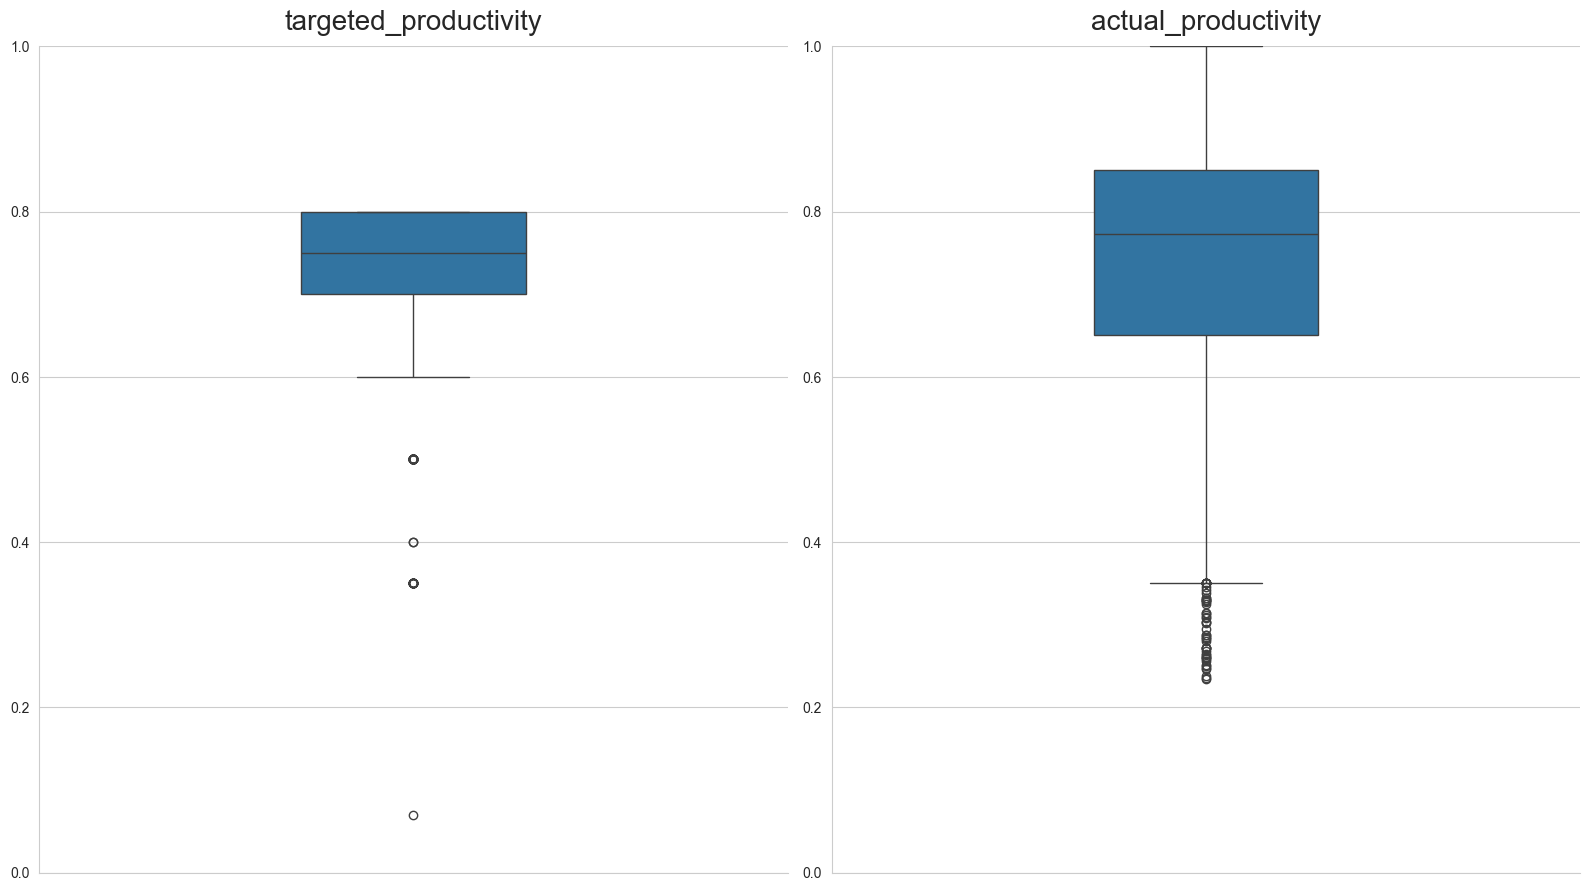

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

for i, col in enumerate(['targeted_productivity', 'actual_productivity']):
    sns.boxplot(data=df, y=col, ax=axes[i], showfliers=True, width=0.3)
    axes[i].set_ylim(0, 1)
    axes[i].set_title(col, fontsize=20, y=1.01)
    axes[i].set_ylabel('')


plt.tight_layout()
sns.despine()
plt.show()

Seeing our plot, we could simply create categories based on final productivity values (e.g. Poor, Good, Excellent). Alternatively, we could classify our observations as either: exceeding targets or missing targets.

We will perform our second idea as this creates a simple binary classification.

In [245]:
# Create category based on actual_productivity > target_productivity or not.

df['exceeds_target'] = np.where(df['actual_productivity'] >= df['targeted_productivity'], 1, 0)

In [246]:
df.sample(5, random_state=42)

,department_sewing,quarter,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,exceeds_target
921,1.0,4.0,3.0,1.0,0.6,22.53,708.0,5040.0,0.0,0.0,0.0,1.0,42.0,0.268214,0
321,1.0,3.0,2.0,6.0,0.8,11.41,1028.0,4380.0,50.0,0.0,0.0,0.0,31.0,0.800359,1
101,0.0,1.0,3.0,8.0,0.8,2.90,0.0,1440.0,0.0,0.0,0.0,0.0,8.0,0.681061,0
920,0.0,4.0,3.0,2.0,0.7,3.90,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.325000,0
58,0.0,1.0,1.0,7.0,0.8,2.90,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.667604,0


In [247]:
# Create copy for model building (to preserve original columns in df)

df_copy = df.copy()

In [248]:
# Drop unnecessary columns in copied df

df_copy.drop(columns=['targeted_productivity', 'actual_productivity'], inplace=True)

Now we can work on building our model, as well as playing around with which features we want to use.

## Model Building (Tree)

### Create Feature and Target Variables

In [249]:
X = df_copy.drop(columns=['exceeds_target'])
y = df['exceeds_target']

### Split Data

In [252]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### Instantiate Tree Classifier and Find Optimal `ccp_alpha`

Lets choose not to set a `max_depth`, but use an optimal `ccp_alpha` to prune the tree.

In [250]:
from sklearn.tree import DecisionTreeClassifier

In [253]:
cost_tree = DecisionTreeClassifier(random_state=42)
cost_path = cost_tree.cost_complexity_pruning_path(X_train, y_train)

In [254]:
subtrees = []

for alpha in cost_path.ccp_alphas:
    subtree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    subtree.fit(X_train, y_train)
    subtrees.append(subtree)

In [255]:
ccp_alphas_slice = cost_path.ccp_alphas
subtrees_slice = subtrees

In [256]:
subtree_scores = [subtree.score(X_test, y_test) for subtree in subtrees_slice]

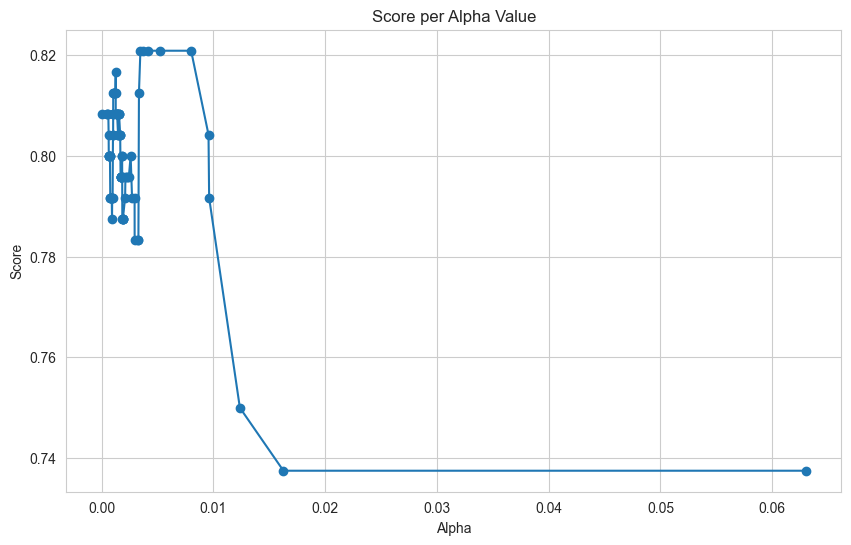

In [257]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10.0, 6.0]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Score")
ax.set_title("Score per Alpha Value")
ax.plot(ccp_alphas_slice, subtree_scores, marker="o")
plt.show()

We can see that our optimal ccp_alpha value lies between 0.003 and 0.008. Let's verify the exact value.

In [258]:
alpha_scores = tuple(zip(ccp_alphas_slice, subtree_scores))
print(max(alpha_scores, key=lambda x:x[1]))

(np.float64(0.0034796959482513642), 0.8208333333333333)


Based on our results, we can create our tree with a `ccp_alpha` of **0.00348**

## Model Building With Optimal `ccp_alpha`

In [286]:
optimal_ccp_alpha = max(alpha_scores, key=lambda x:x[1])[0]

In [287]:
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha)

In [288]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(0.0034796959482513642),
                       random_state=42)

In [289]:
tree.score(X_test, y_test)

0.8208333333333333

In [290]:
y_pred = tree.predict(X_test)

In [291]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        63
           1       0.90      0.85      0.88       177

    accuracy                           0.82       240
   macro avg       0.77      0.79      0.78       240
weighted avg       0.83      0.82      0.82       240

[[ 46  17]
 [ 26 151]]


### Cross-Validation

Lets get our cross-validation score to verify whether our model will work with varying folds of test data.

In [307]:
from sklearn.model_selection import cross_val_score

In [308]:
tree = DecisionTreeClassifier(random_state=42)
print(cross_val_score(tree, X, y, cv=5).mean())

0.7025174337517435


In [309]:
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha)
print(cross_val_score(tree, X, y, cv=5).mean())

0.7835878661087865


We can see that our optimal `ccp_alpha` parameter value, with the pruning it provided, allowed our model to achieve an 8% higher accuracy result in classifying our data.

## Model Building with `GridSearchCV`

Let's try creating a model with a grid search and seeing whether we yield more accurate results with the best parameters.

In [310]:
from sklearn.model_selection import GridSearchCV

In [325]:
params = {
    'ccp_alpha': [0.0034796959482513642, 0],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7]
}

In [326]:
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=5, n_jobs=-1)

In [327]:
grid.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0034796959482513642, 0],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]})

In [328]:
best_params = grid.best_params_
best_score = grid.best_score_
print('Best params:\n',best_params, f'\n\nwith score: ', best_score)

Best params:
 {'ccp_alpha': 0.0034796959482513642, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2} 

with score:  0.789410739191074


In [331]:
best_estimator = grid.best_estimator_

In [334]:
best_estimator.score(X_test, y_test)

0.8333333333333334

In [336]:
y_pred = best_estimator.predict(X_test)

In [337]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.65      0.67        63
           1       0.88      0.90      0.89       177

    accuracy                           0.83       240
   macro avg       0.79      0.77      0.78       240
weighted avg       0.83      0.83      0.83       240

[[ 41  22]
 [ 18 159]]


With our grid search and optimal parameter findings, we achieve a higher cross-validated mean score on our overall data, as well as a slightly higher score on our testing data.

Now lets try with a random forest.

## Model Building (Random Forest)